start this python session with:

ipython notebook --pylab inline current_measurement_requirements.ipynb

The 'inline' prints graphs inline.


In [3]:
from IPython.display import Image
import sympy
import math



###  Current Measurement Board Requirements 

* Must have a gain of 60
* Must have a GBW of 100kHz * 60 = 6MHz
* Must measure current range of (+-500uA, +-500mA)
* Must have a maximum differential voltage of >= 25mV
* Must have single ended analog line out
* Must have low current ground reference
* Must have two oscilloscope channels available: instrumentation_amp_out, Vref, and earth GND
* Must be possible to run on two CR2032 coin cells or on power from external power
* Must be able to short instrumentation amp terminals to check offset voltage
* Must have universal pad for different shunt resistors on end of I.A.
* Must have an onboard ADC.
* Must have SPI Interface of 25Mbits/s for the ADC.
* Must be able to sample the outputs of the differential op amp with an oscilloscope
* Must have >= 16bit resolution
* Must have disable jumper on SPI ADC
* Must be able to have ADC sample from instrumentation amp output or reference voltage
* Must have EN line on ADC
* Should have 0603 pads for filtering on differential end of I.A.
* Must have signal via + GND clip soldermask
* Should size shunt vias to accept 0.1" terminal block
* Should have two vias in each of three scope probes (this is to land the pointy scope probe)
* Should have 1.1mm diameter via for scope probe

It is convenient to define a maximum shunt voltage across the two inputs of the current sense amp.  Choose a shunt voltage of 50mV.  Given a 12 bit bipolar input range, this equates to about 50mV/2048 =~ 25uV minimum resolution  

In [4]:
shunt_voltage_max = .05 # 50mV max shunt voltage
sig_min = shunt_voltage_max/(2**11)
sig_min

2.44140625e-05

[-40, -20, 0, 20, 40, 60, 80]
[3.5e-05, 4e-05, 5e-05, 6e-05, 6e-05, 6e-05, 5e-05]
[-0.0022, -0.002, -0.0017, -0.0015, -0.0013, -0.0009, -0.0006]
[-0.00018, -0.00012, -0.0001, -7.5e-05, -5e-05, -2.5e-05, 0]
[(-40, 0.0006999999999999999), (-20, 0.0008), (0, 0.001), (20, 0.0012000000000000001), (40, 0.0012000000000000001), (60, 0.0012000000000000001), (80, 0.001)]


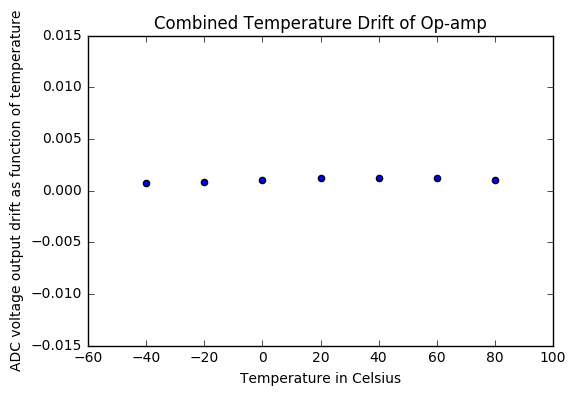

In [6]:
#  Temperature Offset

ad8210_offset_temp_drift = [(-40,35E-6),(-20,40E-6),(0,50E-6),(20,60E-6),(40,60E-6),(60,60E-6),(80,50E-6)]
max1144_offset_temp_drift = [(-40,-.0022),(-20,-.002),(0,-.0017),(20,-.0015),(40,-.0013),(60,-.0009),(80,-.0006)]
# offset error of the LTC231214 is given in LSB error.  Worst case, assume 4.096V reference.
lsb_error = 4.096/2**14
ltc231214_offset_temp_drift = [(-40,-.00018),(-20,-.00012),(0,-.0001),(20,-7.5E-5),(40,-5E-5),(60,-2.5E-5),(80,0)]
ad8210_gain = 20
nterms = len(ad8210_offset_temp_drift)
temp_drift = [[None,None] for _ in xrange(nterms)]
temp_array = [[None] for _ in xrange(len(ad8210_offset_temp_drift))]
offset_array_ad8210 =  [[None] for _ in xrange(len(ad8210_offset_temp_drift))]
offset_array_max1144 = [[None] for __ in xrange(len(max1144_offset_temp_drift))]
offset_array_ltc231214 = [[None] for __ in xrange(len(ltc231214_offset_temp_drift))]
for  idx in (range(nterms)):
    temp_array[idx] = ad8210_offset_temp_drift[idx][0]
    offset_array_ad8210[idx] =  ad8210_offset_temp_drift[idx][1]
    offset_array_max1144[idx] = max1144_offset_temp_drift[idx][1]
    offset_array_ltc231214[idx] = ltc231214_offset_temp_drift[idx][1]
print temp_array
print offset_array_ad8210
print offset_array_max1144
print offset_array_ltc231214
for i in range(nterms):
    temp_drift[i] = (temp_array[i],offset_array_ad8210[i]*ad8210_gain)
print temp_drift


import matplotlib.pyplot as plt
plt.scatter(*zip(*temp_drift))
plt.title('Combined Temperature Drift of Op-amp')
plt.xlabel('Temperature in Celsius')
plt.ylabel('ADC voltage output drift as function of temperature')
plt.show()


[(-40, 1.4893617021276593), (-20, 1.7021276595744683), (0, 2.127659574468085), (20, 2.5531914893617027), (40, 2.5531914893617027), (60, 2.5531914893617027), (80, 2.127659574468085)]


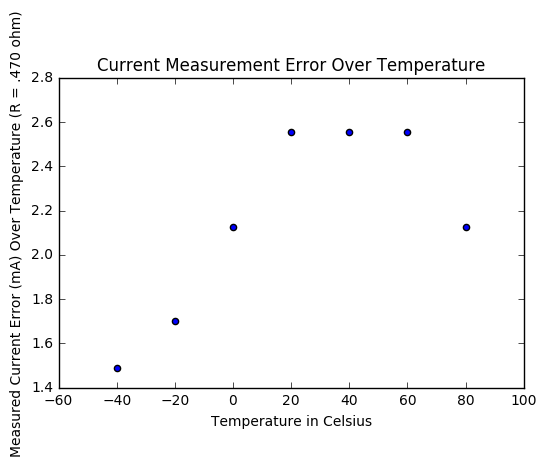

In [6]:
r = .470
i_drift_ma = [(t[0], t[1]*1000/r) for t in temp_drift]
print i_drift_ma
plt.scatter(*zip(*i_drift_ma))
plt.title('Current Measurement Error Over Temperature')
plt.xlabel('Temperature in Celsius')
plt.ylabel('Measured Current Error (mA) Over Temperature (R = .470 ohm)')
plt.show()

In [7]:
#  Bandwidth of the ADP8210
#  The Bandwidth is about 1MHz as illustrated in graph below

Image(filename='pictures/adp8210_smallsignal_gain.png')

IOError: [Errno 2] No such file or directory: u'pictures/adp8210_smallsignal_gain.png'

In [ ]:
#  Noise
#  0.1Hz to 10Hz, 2.3uV p-p
#  spectral noise 110 nV/sqrt(Hz)

# Consider the BW of the opamp (250kHz).
noise_hf = 110E-9/((250E3)**0.5)
print noise_hf
type(noise_hf)
print "noise_hf = %06.10f \n" %noise_hf

###  Offset Error AD8418

Maximum +-400uV drift over temperature.  This is kind of high considering that our minimum resolved signal (sig_min) is 25uV.  Also there is not a graph of the temperature drift.  The offset drift over temperature is not bad (less than 5uV over our region of interest).

![Offset Drift of the AD8418 is well below our 25uV minimum signal](./pictures/AD8418_offset_drift_over_temp.png)


The distribution of different AD8418 chips offset over temperature is centered at -35uV, with a narrow distribution that doesn't go beyond +-100uV.  

![](./pictures/AD8418_offset_voltage_distribution.png)

Given that the output is relatively stable over temperature, it makes sense to tune out our offset voltage in the circuit (or just ignore it and hope for the best which will only lose us a bit or two of resolution probably).




###  Bipolar AD8418

The AD8418 has a bipolar input range.  

###  Common Mode Input Range AD8418

The AD8418 has a -2V, +70V common mode input range.

###  Input Impedance AD8418

The datasheet gives an input bias current of 130uA.  Given that we are trying to detect currents down to 500uA, this is acceptable (though not great).  

### Output Impedance AD8418

The output impedance of the AD8418 (with a load resistance of 15kOhms) is 2 ohms.  The range is (.015V, Vs-.020V) which is nearly rail to rail.  The AD8418 will feed a high impedance active low pass filter, or perhaps an oscilloscope probe, or a relatively high impedance ADC front end, so the performance is probably adequate.

### Bandwidth AD8418

The AD8418 is not high bandwidth.  The performance starts to fall off above 300kHz.  The gain is still useful up to 1MHz.  This is adequate performance for measuring sub 100mA current consumption through multi-microfarad bypass networks.  For instance, a 50mV voltage drop caused by a 100mA current on a 10uF bypassed signal will take 5us (i.e. a 200kHz event).  So we'd really capture all of our current consumption events with a 2MHz sampling frequency (10 x the 200kHz resolves the waveform pretty well).  Unfortunately the gain on the current sense monitor is unit at about 1.5MHz.  So... good enough.

![](./pictures/AD8418_small_signal_bw.png)



In [ ]:
0.05*1E-6/0.1


###  Power Supply AD8418

The operating voltage of the AD8418 is (2.7V, 5.5V).  

The absolute max values for the power pins are 6V which is kind of weany, but good enough.

##  Selection of low pass op amp

Possible candidates:

AD8628     Analog Devices, Chopper stabilized, auto zero.  very low offset voltages.  Very low noise.  Power: (2.7V, 5V).  Rail to rail.  

LTC6255     Linear Technologies, Comes in 1,2,4 pack, low offset voltages ( 

.... wait a second, we don't need to worry about offset voltage or noise particularly, because with a gain of 20 from the front end current monitor, and a shunt voltage of between 20mV and 50mV, and a reference voltage on the ADC of 3.0V/2, then we only need an additional gain of 1.5 or 4. 

Here's a good one:

ADA4805   Analog Devices, rail to rail, low voltage (4.5V, 10V), low offset voltage (125uV max), Low noise (8Hz 1/f, 6nV/sqrt(Hz)).  The input common mode voltage range is:  (VS − 0.1 V to +VS − 1 V).    GBW = 100MHz+.  This device is a little bit expensive at USD2.53 q25 for the SOT23 single opamp package.  Also available in SC70-6 for USD3.17.  This is a high performance low power device that is the chip to beat.  

FAN4852    Fairchild/OnSemi, not quite rail to rail (output swing to within 10mV of either rail), low voltage (2.5V, 5V),  input common mode voltage range is: (-0.2V, 2.1V), low offset voltage (1.2mV worst case over temp), GBW = 9MHz, input noise 11nV/sqrt(Hz), USD.81 q25.  Available in 8MSOP.  The noise specifications for this part are mostly missing.  This is probably a good enough op amp.





###  opamp requirements in relation to the LT2312

The LT2312 datasheet lists two requirements for the input amplifier to the ADC (pg 12 of datasheet):

Maximum Output Impedance:  The amplifier must have an output impedance < 50 ohms at the operational bandwidth.
  The FAN4852 has an output impedance of 6 ohms at 6MHz.  

Minimum Bandwidth:  The closed loop bandwidth must be > 50MHz to ensure adequate settling time for 12 bit signals to allow full sampling throughput.  
  The FAN4852 has a 9MHz bandwidth.  


In [ ]:
#  Calculation of ADC bandwidth

Cadc = -2E-6/(math.log(.99975)*50)
print Cadc

In [ ]:
#  Tim's calculation of the bandwidth requirement
#  The Tacq acquisition time of the ADC is 600ns, and the conversion time is 1400ns.  
#  Therefore the signal has to fall to 12 bits resolution within 600ns
#  Consider a falling signal
#  tadc = 600E-9
#  1./2**12 = math.exp(-tadc/tau)  
#  math.exp(-n) = 1./(2**12)        #  The signal falls from unity to 1/4096 in n time constants
#  n = 8.3
#  frequency = 1./600ns  = 1.66 MHz
#  frequency * n = 13.78MHz
#  This suggests that a 14MHz opamp driving the input of the ADC would be adequate to get the full 500ksps sampling
#  The bandwidth of the FAN4852 is 9MHz (with a 5V supply) which will probably be adequate given that we really care about 
#  a 100ksps.  The LT2312-12 recommends some >100MHz opamps such as the LT6200, but these cost USD 3, and are single packages
#  while the FAN4852 is only USD .35 for a dual package.  Therefore, proceed with the FAN4852 as it is probably barely good enough
#  not to notice any bandwidth limitations.


##  Choosing the Filter Topology and Type

Use a multiple feedback low pass filter.  Use two stages (the FAN4582 opamp is a dual package which makes this convenient).  Use a Bessel type filter so that the phase delay is constant.  
![](./pictures/multiple_fb_lp.png)

Use the reference documentation in: 

http://www.analog.com/media/en/training-seminars/design-handbooks/Basic-Linear-Design/Chapter8.pdf?doc=ADA4661-2.pdf

![](/pictures/bessel_chart.png)


![Multiple Feedback Topology](pictures/MFB.png)

*Bessel Filter Topology and Calculator.  Page 8.92 of Analog's Basic Linear Design*

In [9]:
# script to generate passive values for low pass filter
# Bessel Filter Values for 2nd order filter, page 8.48 from reference document:
Fc = 500000   #  Cutoff frequency in Hz
a1 = 1.916    #  alpha value for first stage of 4th order low pass bessel filter
a2 = 1.2414   #  alpha value for second stage of 4th order low pass bessel filter
F1 = 1.4192   #  Frequency cutoff normalization value for first stage of low pass bessel filter
F2 = 1.5912   #  Frequency cutoff normalization value for second stage of low pass bessel filter
"""
The shunt voltage is 20mV max,
The reference voltage is 2.048V.
The gain of the AD8418 is 20.
20mV * 20 V/V = 400mV
The reference voltage of the LTC2312 is 4.096V which split in half is 2.048V.
Therefore need gain of 2.048/400mV = 5.12
In two stages:  5.12**.5 = 2.26 , so round to 2.2

"""

H1 = 2.2        #  first stage gain. 
H2 = 2.2        #  second stage gain
C5 = 220E-12     #  Choose C5 value
Fc1 = Fc * F1    #  Cutoff frequency in Hz
k1 = 2*math.pi*Fc1*C5
C2 = 4*C5*(H1+1)/(a1**2)
R1 = a1/(2*H1*k1)
R3 = a1/(2*k1*(H1+1))
R4 = a1/(2*k1)

#  For the second stage of the filter, add a zero to the names of the components, i.e. R4 -> R40

C50 = C5    #  C50 set from earlier C5 choice
Fc2 = Fc * F2    #  Cutoff frequency in Hz
k2 = 2*math.pi*Fc2*C50
C20 = 4*C50*(H2+1)/a2**2
R10 = a2/(2*H2*k2)
R30 = a2/(2*k2*(H2+1))
R40 = a2/(2*k2)

print "C5 =  " '{0:.12f}'.format(C5)
print "C2 =  " '{0:.12f}'.format(C2)
print "R1 =  " '{0:.12f}'.format(R1)
print "R3 =  " '{0:.12f}'.format(R3)
print "R4 =  " '{0:.12f}'.format(R4)
print "C50 =  " '{0:.12f}'.format(C50)
print "C20 =  " '{0:.12f}'.format(C20)
print "R10 =  " '{0:.12f}'.format(R10)
print "R30 =  " '{0:.12f}'.format(R30)
print "R40 =  " '{0:.12f}'.format(R40)



C5 =  0.000000000220
C2 =  0.000000000767
R1 =  443.942447735762
R3 =  305.210432818337
R4 =  976.673385018677
C50 =  0.000000000220
C20 =  0.000000001827
R10 =  256.543928531353
R30 =  176.373950865305
R40 =  564.396642768976


In [ ]:
math.log(2.714)


##  Choosing the cutoff frequency of the filter.

The stm32F4 has a 12bit ADCs that can sample up to 32MHz.  (See page 6.3.21 of DM00071990_STM32F42x_Datasheet_Rev_5_Feb_2015.pdf).  The AD8418 has a bandwidth of a little over 1MHz.  
The LTC2312 ADC has a sample rate of 500ksps.  

Given the requirement that the device have a gain band width of 6MHz, with 60 gain at 100kHz.  It makes sense to do a cutoff at 500kHz.  

##  Choosing the gain of the bessel filter

The maximum voltage across the shunt resistor is 50mV.  The gain from the AD8418 is 20V/V (though figure 6 from the datasheet which shows the small signal gain appears as 27dB with a 200kHz cutoff).  The input range of the ADC either on board (LTC2312) or offboard (STM32) will be 3.3V (round down to 3V). This means that we would only need a gain of 3 from the Bessel active filter.  All things the same,  Let's scale the voltage across the shunt resistor to 20mV which will mean we need a gain of 7.5 from the bessel filter. 

###  Bessel Filter Simulation Results

The LT spice filter simulation shows a bandwidth of 683 kHz.  The phase shift at low frequencies is near zero and begins to rise at higher frequencies (at 100 kHz -25 degrees).  Note that the log scale in LTspice graph is 20log, so the -3dB cutoff is actually -6dB cutoff.  


<img src="pictures/bessel_filter_lt.png" alt="Drawing" style="width: 600px;"/>

*Bessel Filter schematic*

<img src="pictures/bessel_sim.png" alt="Drawing" style="width: 600px;"/>


*Bessel Filter Simulation results with 683 kHz cutoff*



###  Validation Tests of the Current Monitor Board

First do a basic validation test by measuring the current over a 75 mOhm resistor at J260.  Probe the two differential sides of the sense resistor with the VSHUNT_P and VSHUNT_M.  Power the Imon board with 5V.  Probe the output of the ADP8418 VSHUNT_20X with the oscilloscope.  Considering that the peak write currents are about 100mA (this is a new EMMC board).  

(.075 ohms) x (0.100 A) * (20 V/V) = 150

This is approximately the peak current that is observed on the scope.  The basic validation test is passed.  


First, a **whoopsy! The +INPUT to the two op amps of the Bessel Filter should be jumpered to the VREF signal.**  This is done by mod-wire on the first demonstration board. 



Now let's do a DC accuracy test on **board number 1**.  Make a resistive divider of 10k/270/10k between 4V and GND.  Probe across the 270 ohm resistor.  The voltage difference across the 270 ohm resistor is 54.3 mV (according to the new Fluke).  The common mode voltage is 2.0V, the VSHUNT_20X_OUT measures 2.915V (with the new Fluke).  The ADP8418 should show:

(54.3 mV) x (20) = 1.086 V  

2.915V - 2.048V (VREF) = 867 mV

1.086 V + 2.048V (VREF) = 3.134 V.  

With the two differential inputs DM and DP at 2.00V (and 0 differential voltage), the VSHUNT_20X_OUT measures 2.033V.  VREF measures 2.048V.  

The 20% error in DC measurement is excessive. Something smells bad about this particular board... Let's try board number 2.

**Now try board number 2**

Vdd = 5V
VREF = 2.048V
Vcommon mode = 3.0V
Vdifferential = 0V       VSHUNT_20X_OUT = 2.032V     An offset error of -16mV (0.78% error)
Vdifferential = 69mV     VSHUNT_20X_OUT = 3.408V     (.069V x 20) + 2.048V = 3.428V  (0.58% error)

The DC measurement with common mode around 3V seems to work OK (within 1%).  Now try some AC measurements.  Set up a four resistor bias network for an NPN 2N3904.  Set the VDD rail at 5V, bias the base to 1.1V and then capacitively couple a 26 kHz, 350mV signal into the base.  Measure the current across a 1.3 ohm sense resistor on the emitter side.  The Common mode voltage in this measurement is between 13mV and 126mV.  The differential voltage across the sense resistor is very noisy, say about 25mV.  The VSHUNT_20X_OUT records 545mV peak.  

25mV x 20 = 500mV (error factor of 9%, however, the differential signal on the oscilloscope is very noisy - other reasonable measurements group right around the gain factor of 20 V/V, both above and below, within 2V.  Note that this signal is near the negative rail because I put the sense resistor on the emitter for some reason.)  This measurement verifies that the analog



blue channel displays 34mV less than green channel
yellow 2.673  (channel 1)  add 27mV
green 2.700 (channel 2)
blue 2.667 (channel 3)     add 34mV
**  AC signal 1kHz **
Vcommon Mode = 3.0V
Differential voltage = 59mV  (59mV * 20 = 1.18V)
VSHUNT_20X_OUT = 3.073V   (3.073V - 2.048V = 1.025V)  This is a 15% error
VSHUNT_FILTERED = 0V  (This is because the differential voltage input is too large and is railing)

**  AC signal 10kHz  **
Vcommon Mode = 3.0V
Differential Voltage =54mV
VSHUNT_20X_OUT = 3.086V (3.086V - 2.048V = 1.038V)  This is a 4% error
VSHUNT_FILTERED = 0V  (This is because the differential voltage input is too large and is railing)

The problem with these tests is that the oscilloscope is not a precision voltage measurement device.  Each channel has an offset voltage.  The noise on each channel is about +-10mV at least.  This makes determining voltages down to less than 5mV to be a bit of guesswork and approximation.  The shunt voltages that the imon board is designed to measure in the field will probably be on the range of 20mV to 50mV.  This is already starting to get close to the noise floor of the oscilloscope.  The two measurements show an agreement of 

**  AC signal 50kHz  **
Vcommon Mode = 3.0V
Differential Voltage = 15mV
VSHUNT_20X_OUT = 2.356V (2.356V - 2.048V = .308V) This is an error of 2%
VSHUNT_FILTERED = 3.542V (3.542V - 2.048V = 1.494V) gain of 4.4 in op amp stages. .308V * 4.4 = 1.355V This is an error of 10%.


**  AC signal 500kHz  **
Vcommon Mode = 3.0V
Differential Voltage = 28mV  (28mV * 20 = 560mV)
VSHUNT_20X_OUT = 2.360V (2.360V - 2.048V = .3119V)  This is a 75% error
VSHUNT_FILTERED = 3.532V (3.532V - 2.048V = 1.484V)  gain of 4.4 in op amp stages.  .3119V * 4.4 = 1.372V This is an error of 8%.  Note that there is some phase lag in the 500kHz signal.

** Results of bandwidth testing:**
The resolution and noise of the oscilloscope limit the precision of small voltage measurement.  The errors are all reasonably close for the AC performance of the current measurement board.  






###  Improved Test Setup

Use a transformer to couple the AC signal into the 3.0V DC offset.  

<schematic picture here>

For all calculations in charts below, the numbers for V_20X_OUT = VSHUNT_20X_OUT are (measurement - 2.048V).  Likewise with the V_FILTERED numbers.  A negative sign indicates the DM is higher voltage than DP.  

For the DC measurement.  Place 3.003V across the 1.3 and 216 ohm resistive divider.  Measure the voltage across the 1.3 ohm resistor with the Fluke(measures 16mV).  Compute the voltage as a resistive divider calculation.  (3.003V * 1.3/(1.3+216) = 17.9mV).  

DC voltage measurement with fluke:  16.1mV
VSHUNT_20X_OUT computation:  16.1mV * 20 = .322V
V_FILTERED_OUT computation: 16.1mV * 20 * 4.4 = 1.4168V

Should show on the VSHUNT_20X_OUT: (16.1mV * 20) + 2.048V = 2.370V
                               OR:  2.048V - (16.1mV * 20) = 1.726V
Should show on the V_FILTERED_OUT: (16.1mV * 20 * 4.4) + 2.048V = 3.464V
                               OR: 2.048V - (16.1mV * 20 * 4.4) = .631V

**DC Measurements**
<pre>
'''
|  N  |  VREF  | V_20X  | V_20X-VREF  |  V_FILT  |  V_FILT-VREF |  V_20X (%) |  V_FILT (%)  |
|-----|--------|--------|-------------|----------|--------------|------------|--------------|
|  1   |  2.047  | 1.719   |  -.328        |  .346      -1.701       |    1.8%     |  20%
|  2   |  2.046  | 1.694   |  -.354        |  .320    |  -1.728       |    10%      |  22%
|  2   |  2.046  | 2.376   |  .330         |  3.664   |  1.618        |   2.4%      |  14%
|  3   |  2.047  | 
|  3   |  2.047  | 2.376   |  .330         |  3.645   |  1.599        |   2.4%     |  12.8%
|  4   |  2.046  | 2.376   |  .330         |  3.643   |  1.597        |   2.4%      |  12.7%
|  5   |  2.047  | 2.382   |  .334         |  3.698   |  1.651        |   3.7%      |  16.5%
|  6   |  2.047  | 2.383   |  .336         |  3.668   |  1.621        |   4.3%      |  14.4%
|  7   |  2.047  | 2.372   |  .324         |  3.632   |  1.584        |   0.6%      |  11.8%
|  8   |  2.047  | 2.373   |  .325         |  3.630   |  1.583        |   0.9%      |  11.7%
|  9   |  2.046  | 2.382   |  .336         |  3.680   |  1.632        |   4.3%      |  15.2%
'''
<pre>

The resistor values are 220 ohms (measure 216 ohms), and 1.3 ohms (measures 1.3 ohms)

The waveform measured across both resistors is 1.660 V as measured on a single channel (2) of the infiniium scope.  This should put a 10mV signal across the 1.3 ohm resistor.  

Check that the IMON board does not load the transformer.  Place the IN+ (VSHUNT_P) on the 3.0V node and the IN- on the resistive divider node.  This is because fig. 8 on the AD8418 graph shows that the input current comes from IN+ and virtually none from IN-.  

This setup is a bit weird because the current direction is changing positive negative each cycle.  

**1kHz Measurements**
||=  N  ||= V_20X amplitude pk-pk  ||  V_FILT amplitude ||=  V_20X (%) ||=  V_FILT (%)  ||
||   8  ||  .175                   ||  .857             ||   14.2%     ||    -3%        ||

Above 100kHz, it looks like the gain starts to roll off quite quickly.

###  Discussion of Measurement/Calibration errors on the IMON board

The analog stages of the imon board are showing consistent errors in measurement - 4.3% for the ADP8418 and 15% for the filter stage.  This is too much.  Would like to see 1% error range.   Possible sources of the error are:

Input offset error in any of the op amps or current measurement chip

Improperly calibrated shunt resistors that fail to take into account lead resistance and contact resistance

Improperly calibrated test equipment

**Input Offset Error**
The AD8418 has an initial gain error over temperature range of +-0.2%.  The input offset voltage is typically 200uV, max over temperature 400uV.  In the case of the 1.3ohm shunt resistor, the voltage error would be:


In [4]:
dc_shunt_voltage = 3.003*(1.3/(1.3+216))
input_offset_voltage_typ = 200.E-6
iov_error = input_offset_voltage_typ/dc_shunt_voltage
print "Input Offset Error = %f" %iov_error

Input Offset Error = 0.011132


**Input Offset Voltage test of Board number 2**

*Measure the output of the analog stages when the inputs are shorted*

Measure the ADP8418 input offset performance with the inputs SHUNT_M and SHUNT_P shorted together and a DC common mode bias put on the inputs.
Power the board with 5V.
Measure the voltage with the Fluke
The "Error (mV)"  is the difference in VSHUNT_20X from the expected value (VSHUNT_20X should equal VREF with the inputs shorted).  
The "IOE(uv)" is the input offset error is the Error/20.  The AD8418 lists 200uV as the typical input offset error.
The VSHNT_F is VSHUNT_FILTERED (V)

<pre>
'''
**Measurement of outputs with DM/DP input shorted**
| Board  |  DC Comm |  VREF_FILTERED |  VSHUNT_20X  | Error (mV) | IOE(uV) | VSHNT_F |
|--------|----------|----------------|--------------|------------|---------|---------|
|   2    |  2.5V    |  2.050V        |  2.033V      |  -17mV     |  850uV  |  1.973V |
|   5    |  2.5V    |  2.048V        |  2.034V      |  -14mV     |  700uV  |  1.979V |  



'''
<pre>

Hmmmm, maybe the load impedance on the output of the ADP8418 is too small.  The datasheet lists a 25kOhm load impedance on table 2: OUTPUT (25kOhm)

Add a 24k resistor from VSHUNT_20X to GND.  

<pre>
'''
**Measurement of VSHUNT_20X with 24k load**
| Board  |  DC Comm |  VREF_FILTERED |  VSHUNT_20X  | Error (mV) | IOE(uV) |
|--------|----------|----------------|--------------|------------|---------|
|   2    |  2.5V    |  2.048V        |  2.033V      |  -15mV     |  750uV  |


'''
<pre>

Changing the output impedance seen by the AD8418 does nothing to the error.  Oh look, there is a graph in the datasheet that says the amplifier loses accuracy when the differential input voltage is below 5mV. This means that we can't calibrate the amplifier by tying the inputs together (0 differential volts).  This would help to explain why we are seeing a much higher input offset error than we expected.

<img src="pictures/Error_vs_Diff_Input_Voltage.png" alt="Drawing" style="width: 600px;"/>

*Graph of the output error (VSHUNT_20X) vs input differential voltage.  Below 5mV, the error climbs asymptotically toward infinity.* 


**Test of output accuracy with a 24k load on AD8418 output and a nonzero differential input voltage**

Provide 5V power to the board.

Provide a 12.2mV reference voltage, at 2.5V common mode.  (This is a 2.2k, 11, 2.2k resistive divider.  The voltage is measured across the VSHUNT_P/VSHUNT_M terminals with the Fluke meter on mV mode.)

The output to the AD8418 is a 24k resistor (the Bessel filter is disconnected by removing R1)

<pre>
'''
**Measurement of VSHUNT_20X with 24k load**
| Board  |  DC Comm |  VREF_FILTERED |  VSHUNT_20X  | Error (mV) | IOE(uV) | Error(%) |
|--------|----------|----------------|--------------|------------|---------|----------|
|   2    |  2.5V    |  2.048V        |  2.277V      |  -15mV     |  750uV  |  6.1%    |

'''
<pre>

Realize that the 10 ohm input resistors are adding a significant amount of error due to input current.  Consider the input bias current graph that shows that the positive input pin of the AD8418 requires 150uA or more of bias current in our normal operating range (3.0V common mode).  This translates to an error of 15mV which is what we've been consistently seeing. 

<img src="pictures/bias_current.png" alt="Drawing" style="width: 600px;"/>

*Graph of input bias current.  The VSHUNT_P pin has a significant bias current while the VSHUNT_M pin has much less input bias current.*

Test this behavior by shorting across the R7 and R8 pins with a tweezers while monitoring the output voltage.  Notice that shorting R8 (the DM side) does nothing, but that shorting R7 causes a 15mV change in the output voltage.  Therefore, replace the R7 and R8 resistors with jumpers.  Run the test again (5V VDD, 2.5V common mode, 24k VSHUNT_20X load, R7 = R8 = 0 ohms, VSHUNT_P - VSHUNT_M measured as 12.2mV)

<pre>
'''
**Measurement of VSHUNT_20X with 24k load**
| Board  |  DC Comm |  VREF_FILTERED |  VSHUNT_20X  | Error (mV) | IOE(uV) | Error(%) |
|--------|----------|----------------|--------------|------------|---------|----------|
|   2    |  2.5V    |  2.048V        |  2.293V      |  +1mV     |  50uV  |  0.4%    |


'''
<pre>

Using the mV range of the Fluke, and using the VREF_FILTERED as the reference, the VSHUNT_20X = 245.1mV which makes an error of 0.45%








### Check performance of the 4th order Bessel Filter



**Measure the voltage at FILTER1_OUT and FILTER2_OUT Given a small differential input voltage**
Test Conditions:
(5V VDD, 2.5V common mode, 24k VSHUNT_20X load, R7 = R8 = 0 ohms, VSHUNT_P - VSHUNT_M measured as 12.2mV, R1 = 442 ohms)

<pre>
'''

**Measurement of Bessel Filter Stages**
| Board  |  DC Comm |  VREF_FILTERED |  VSHUNT_20X  | STAGE1_OUT | STG1 Err(%) | STAGE2_OUT | STG2 Err(%) |
|--------|----------|----------------|--------------|------------|-------------|------------|-------------|
|   2    |  2.5V    |  2.048V        |  2.293V      |  1.506V    |   0.5%      |  3.250V    |  0.8%


'''
<pre>

This shows that the analog circuits are accurate within 1% at DC.  Earlier 



<img src="pictures/buffer_amp_requirements.png" alt="Drawing" style="width: 600px;"/>

The requirements of the buffer amp to the AIN input of the LTC2312 are:

1.)  50MHz closed loop bandwidth

2.)  less than 50 ohms output impedance

The FAN4852 has a 9MHz BW, 6 ohm closed loop output impedance.  This does not meet the 1st BW requirement, however it seems to work (at least at DC as would be expected).

<pre>

'''
**Measurement of Bessel Filter Stages with high impedance load (no LTC2312, J31 cut)**
| Board  |  DC Comm |  VREF_FILTERED |  VSHUNT_20X  | STAGE1_OUT | STG1 Err(%) | STAGE2_OUT | STG2 Err(%) |
|--------|----------|----------------|--------------|------------|-------------|------------|-------------|
|   2    |  2.5V    |  2.048V        |  2.293V      |  1.506V    |   0.5%      |  3.248V    |  0.6%

'''
<pre>


###  AC test of IMON  

Test the performance of the board with:

R7 = R8 = 0 ohms

No 24k resistor from VSHUNT_20X to GND (The output of the AD8418 only sees R1)

Test setup:

Vdd = 5V

Vcommon Mode = 3.0V

The frequency generator creates a 10kHz, 700mV wave.  This wave is AC coupled (with a 10nF cap) into a resistive divider to 3.0V (10k, 100 ohms).


<img src="pictures/AC_Test.png" alt="Drawing" style="width: 600px;"/>

*Test setup for time domain test of the imon board*

The Agilent scope probes on channels 2 and 3 are each calibrated against the VSHUNT_P source:

channel 2 = 2.906V
channel 3 = 2.866V  

The noise is about +-10mV which makes precision measurements difficult.  The waveform can be observed 

(36mV to -8mV)44mV  VSHUNT_P - VSHUNT_M

(2.46V, 1.65V)  channel 2 VSHUNT_20X

VREF = VREF_FILTERED
Vdiff = VSHUNT_P - VSHUNT_M 

<pre>

'''
**Measurement of Bessel Filter Stages with AC signal**
| Board  |  DC Comm |  freq |  Vdiff |VSHUNT_20X  | Gain  | VSHUNT_FILT | Gain | Total Err(%) |
|--------|----------|-------|--------|------------|-------|-------------|------|--------------|
|   2    |  3.0V    | 10kHz |  32mV  |  579mV     |  18   |   2.855     |  89  |  -8%         |
|   2    |  3.0V    | 100kHz|  32mV  |  627mV     |  20   |   3.047     |  95  |  -2%         |
|   2    |  3.0V    | 250kHz|  27mV  |  700mV     |  25   |   3.5       |  114 |  +17%        |
'''
<pre>

*Note that the noise on small signals makes it difficult to accurately determine the starting voltage.  

At higher frequencies above 100kHz, the edges of the signal begin to round and the higher order harmonic content is lost.  At 250kHz, the gain of the VSHUNT_FILT begins to drop off.







## Conclusion

The IMON board is accurate within 1% for DC measurements with a 5V supply and a common mode voltage near 2.5V.  The AC performance is harder to verify with the oscilloscope resolution, however within the limits of our measurement, the IMON board has a frequency gain out to 250kHz at which point the gain starts to diminish.  Below 100kHz, the waveform has enough harmonic content to be squarish.